In [ ]:
# COLAB: uncomment below to setup for Git
# !git clone https://github.com/C7082-2022/labs-cv-colab

In [ ]:
# COLAB: uncomment below to change directory
# cd labs-cv-colab/03-DL-basics

In [5]:
# setup for images
from IPython.display import Image

# Lab 06 Binary classification

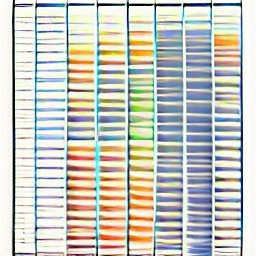

In [6]:
Image("img/craiyon-binary.jpg")
# Craiyon.com "Binary classification" 

## 1 Objectives

So far, we've learned about how neural networks can solve regression problems. 

Now we're going to 
- apply neural networks to classification
- evaluate difference for the loss function
- practice classification outputs for the final layer



## 2 Binary Classification #

Classification into one of two classes is a common machine learning problem. You might want to predict whether or not a customer is likely to make a purchase, whether or not a credit card transaction was fraudulent, whether deep space signals show evidence of a new planet, or a medical test evidence of a disease. These are all **binary classification** problems.

In your raw data, the classes might be represented by strings like `"Yes"` and `"No"`, or `"Dog"` and `"Cat"`. Before using this data we'll assign a **class label**: one class will be `0` and the other will be `1`. Assigning numeric labels puts the data in a form a neural network can use.



## 3 Accuracy and Cross-Entropy

**Accuracy** is one of the many metrics in use for measuring success on a classification problem. Accuracy is the ratio of correct predictions to total predictions: `accuracy = number_correct / total`. A model that always predicted correctly would have an accuracy score of `1.0`. All else being equal, accuracy is a reasonable metric to use whenever the classes in the dataset occur with about the same frequency.

The problem with accuracy (and most other classification metrics) is that it can't be used as a loss function. SGD needs a loss function that changes smoothly, but accuracy, being a ratio of counts, changes in "jumps". So, we have to choose a substitute to act as the loss function. This substitute is the *cross-entropy* function.

Now, recall that the loss function defines the *objective* of the network during training. With regression, our goal was to minimize the distance between the expected outcome and the predicted outcome. We chose MAE to measure this distance.

For classification, what we want instead is a distance between *probabilities*, and this is what cross-entropy provides. **Cross-entropy** is a sort of measure for the distance from one probability distribution to another.

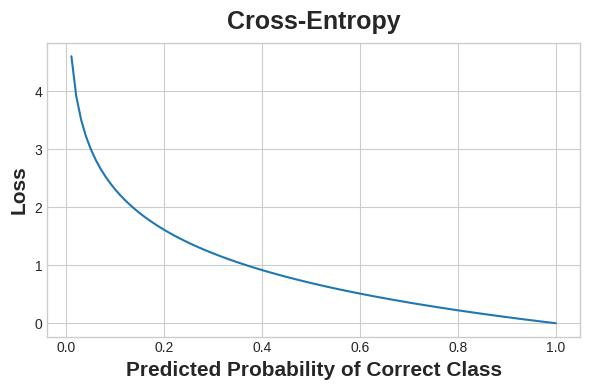

In [8]:
Image("img/6-1.PNG", width = 600)
# Graphs of accuracy and cross-entropy



The idea is that we want our network to predict the correct class with probability `1.0`. The further away the predicted probability is from `1.0`, the greater will be the cross-entropy loss.

The technical reasons we use cross-entropy are a bit subtle, but the main thing to take away from this section is just this: use cross-entropy for a classification loss; other metrics you might care about (like accuracy) will tend to improve along with it.




## 4 Making Probabilities with the Sigmoid Function

The cross-entropy and accuracy functions both require probabilities as inputs, meaning, numbers from 0 to 1. To covert the real-valued outputs produced by a dense layer into probabilities, we attach a new kind of activation function, the **sigmoid activation**.


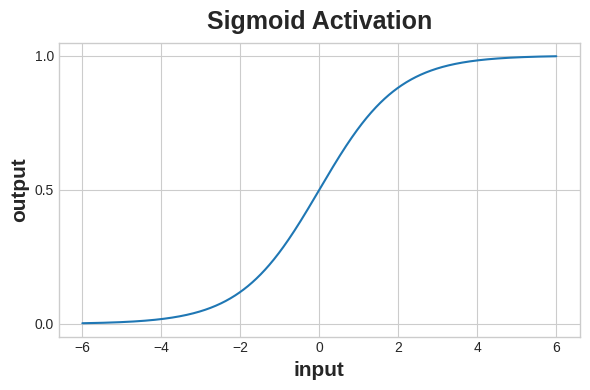

In [9]:
Image("img/6-2.png", width = 600)
# The sigmoid graph is an 'S' shape with horizontal asymptotes at 0 to the left and 1 to the right




To get the final class prediction, we define a *threshold* probability. Typically this will be 0.5, so that rounding will give us the correct class: below 0.5 means the class with label 0 and 0.5 or above means the class with label 1. A 0.5 threshold is what Keras uses by default with its [accuracy metric](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/BinaryAccuracy).



## 5 Example - Binary Classification

Now let's try it out!

The [Ionosphere](https://archive.ics.uci.edu/ml/datasets/Ionosphere) dataset contains features obtained from radar signals focused on the ionosphere layer of the Earth's atmosphere. The task is to determine whether the signal shows the presence of some object, or just empty air.

In [1]:

import pandas as pd
from IPython.display import display

ion = pd.read_csv('data/ion.csv', index_col=0)
display(ion.head())

df = ion.copy()
df['Class'] = df['Class'].map({'good': 0, 'bad': 1})

df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)

df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)
df_train.dropna(axis=1, inplace=True) # drop the empty feature in column 2
df_valid.dropna(axis=1, inplace=True)

X_train = df_train.drop('Class', axis=1)
X_valid = df_valid.drop('Class', axis=1)
y_train = df_train['Class']
y_valid = df_valid['Class']

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V26,V27,V28,V29,V30,V31,V32,V33,V34,Class
1,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,good
2,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,bad
3,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,good
4,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,bad
5,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,good


<br>

We'll define our model just like we did for the regression tasks, with one exception. In the final layer include a `'sigmoid'` activation so that the model will produce class probabilities.

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(4, activation='relu', input_shape=[33]),
    layers.Dense(4, activation='relu'),    
    layers.Dense(1, activation='sigmoid'),
])

<br>

Add the cross-entropy loss and accuracy metric to the model with its `compile` method. For two-class problems, be sure to use `'binary'` versions. (Problems with more classes will be slightly different.) The Adam optimizer works great for classification too, so we'll stick with it.

In [3]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

<br>

The model in this particular problem can take quite a few epochs to complete training, so we'll include an early stopping callback for convenience.

In [4]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

<br>

We'll take a look at the learning curves as always, and also inspect the best values for the loss and accuracy we got on the validation set. (Remember that early stopping will restore the weights to those that got these values.)

In [10]:
# might need colab

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

NameError: name 'pd' is not defined

## 6 Ecercises

Here, you'll build a model to predict hotel cancellations with a binary classifier.

In [ ]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')


<br>

First, load the *Hotel Cancellations* dataset.

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

hotel = pd.read_csv('data/hotel.csv')

X = hotel.copy()
y = X.pop('is_canceled')

X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )

features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]

### 6.1 Define Model

The model we'll use this time will have both batch normalization and dropout layers. To ease reading we've broken the diagram into blocks, but you can define it layer by layer as usual.

Define a model with an architecture given by this diagram:


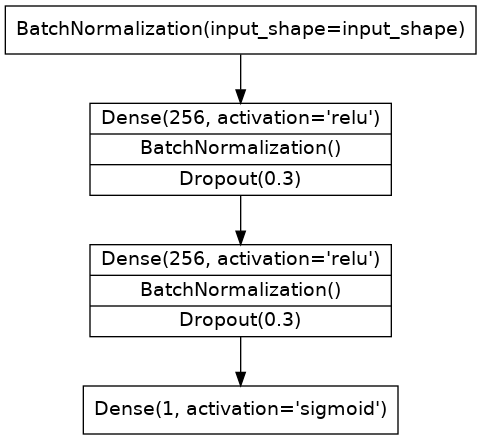

In [11]:
Image("img/6-3.png", width = 600)
# Diagram of network architecture: BatchNorm, Dense, BatchNorm, Dropout, Dense, BatchNorm, Dropout, Dense

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

# YOUR CODE HERE: define the model given in the diagram
# model = ____



### 6.2 Add Optimizer, Loss, and Metric

Now compile the model with the Adam optimizer and binary versions of the cross-entropy loss and accuracy metric.

In [ ]:
# YOUR CODE HERE
# ____




<br>

Finally, run this cell to train the model and view the learning curves. It may run for around 60 to 70 epochs, which could take a minute or two.

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

### 6.3 Train and Evaluate 


What do you think about the learning curves? Does it look like the model underfit or overfit? Was the cross-entropy loss a good stand-in for accuracy?